In [2]:
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys
sys.path.append("..")
import jsq_ps_new.models as jsq
import aux.models as aux
plt.style.use('seaborn-whitegrid')

In [3]:
Rs = range(1, 11)
rhos = [round(x, 2) for x in np.linspace(0.01, 0.99, 99)]

In [4]:
# README: Use the most up-to-date one
data = pd.read_csv('sweep_summary.csv')


def find_best(row):
    A = row['error A']
    B = row['error B']
    C = row['error C']
    D = row['error D']
    E = row['error E']
    F = row['error F']
    if A == min([A, B, C, D, E, F]):
        return 1
    if B == min([A, B, C, D, E, F]):
        return 2
    if C == min([A, B, C, D, E, F]):
        return 3
    if D == min([A, B, C, D, E, F]):
        return 4
    if E == min([A, B, C, D, E, F]):
        return 5
    if F == min([A, B, C, D, E, F]):
        return 6

# Here we obtain the best approx
data['best'] = data.apply(lambda row: find_best(row), axis=1)




# Derived from experiments parameters
infty = 130
mc_limits = { # R: mc_limit
    1: 22, 2:22, 3:22,
    4: 13, 5:7, 6:5, 7:4,
    8:3, 9:3, 10:2
}



# Here we store the best approx. for every (R,rho) pair
approx_data = {}
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in np.linspace(0.01, 0.99, 99):
        rho_r = round(rho, 2)
        method_idx = data[(data['R']==R) & (data['rho']==rho_r)]['best'].values[0]
        best_method = ['A','B','C','D','E','F'][method_idx-1]
        file = f'sweep/method{best_method}/mc_limit={mc_limits[R]}-infty={infty}-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        approx_data[(R, round(rho, 2))] = cdf

In [5]:
uniform_data = {}
for rho in tqdm.tqdm_notebook(rhos):
    for R in Rs:
        cdf = pd.read_csv(f'sweep-uniform/uniform-R={R}-rho={rho}.csv', index_col=0)
        uniform_data[(R, rho)] = cdf

In [6]:
deterministic_data = {}
for rho in tqdm.tqdm_notebook(rhos):
    for R in Rs:
        cdf = pd.read_csv(f'sweep-deterministic/deterministic-R={R}-rho={rho}.csv', index_col=0)
        deterministic_data[(R, rho)] = cdf

In [7]:
expon_data = {}
for rho in tqdm.tqdm_notebook(rhos):
    for R in Rs:
        cdf = pd.read_csv(f'sweep-expon/expon-R={R}-rho={rho}.csv', index_col=0)
        expon_data[(R, rho)] = cdf

In [8]:
def get_wasserstein_U(R, rho):
    return aux.wasserstein_distance(uniform_data[(R, rho)]['cdf'], expon_data[(R, rho)]['cdf'], 0.01)

def get_wasserstein_D(R, rho):
    return aux.wasserstein_distance(deterministic_data[(R, rho)]['cdf'], expon_data[(R, rho)]['cdf'], 0.01)

In [9]:
WUs = []
WDs = []
for R in Rs:
    WUs.append([])
    WDs.append([])
    for rho in rhos:
        WUs[-1].append(get_wasserstein_U(R, rho))
        WDs[-1].append(get_wasserstein_D(R, rho))

In [10]:
minW = min(min([min(row) for row in WUs]), min([min(row) for row in WUs]))
maxW = max(max([max(row) for row in WUs]), max([min(row) for row in WUs]))

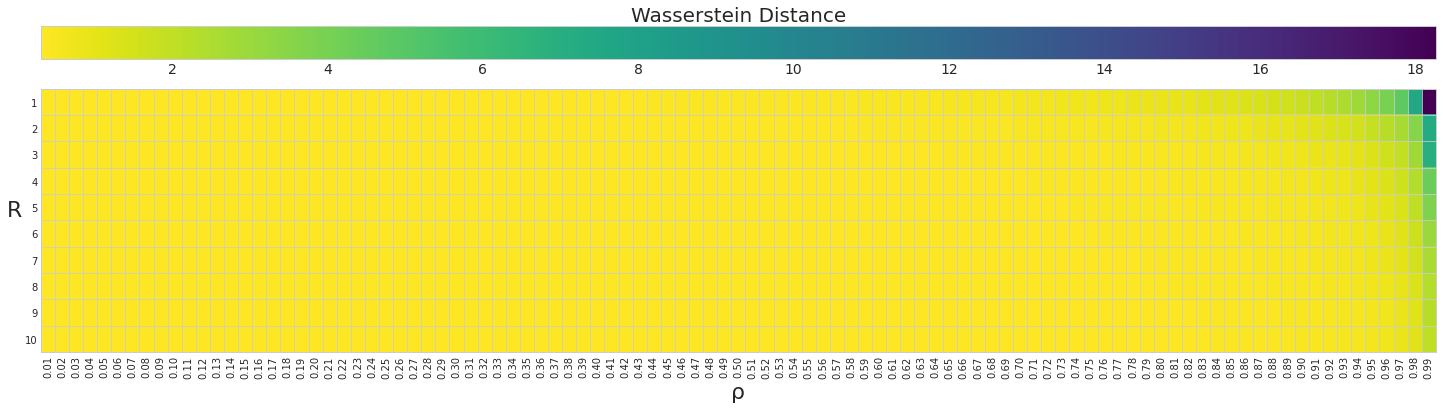

In [12]:
Rs = list(range(1, 11))
rhos = [round(r, 2) for r in np.linspace(0.01, 0.99, 99)]

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(25, 6),  gridspec_kw={"height_ratios":[0.125, 1]})
mappable = ax.imshow(WUs, aspect='auto', cmap='viridis_r', vmin=minW, vmax=maxW)
ax.set_ylabel('R', fontsize=22, rotation=0, labelpad=10)
ax.set_xlabel('ρ', fontsize=22, rotation=0)

# colorbar
cbar = fig.colorbar(mappable, orientation = "horizontal", cax=cax)
cbar.set_label('Wasserstein Distance', fontsize=20, labelpad=-70)
cbar.ax.tick_params(labelsize=14)

# y-ticks
ax.set_yticks([R - 0.5 for R in Rs])
ax.set_yticks([R - 1 for R in Rs], minor=True)
ax.set_yticklabels(Rs, minor=True)
ax.set_yticklabels([])

# x-ticks
ax.set_xticks([r - 0.5 for r in range(len(rhos))])
ax.set_xticks([r for r in range(len(rhos))], minor=True)
ax.set_xticklabels([])
ax.set_xticklabels([str.ljust(str(n), 4, '0') for n in rhos], minor=True, rotation=90,)

fig.savefig('uniform-expon-dists.pdf', bbox_inches='tight')

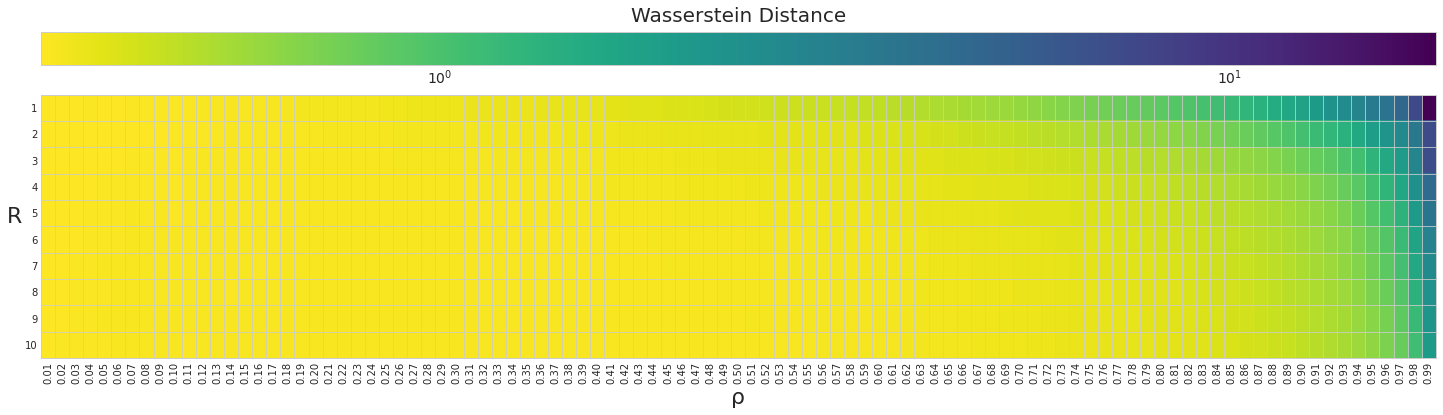

In [13]:
Rs = list(range(1, 11))
rhos = [round(r, 2) for r in np.linspace(0.01, 0.99, 99)]

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(25, 6),  gridspec_kw={"height_ratios":[0.125, 1]})
mappable = ax.imshow(WUs, aspect='auto', cmap='viridis_r',  norm=colors.LogNorm(vmin=minW, vmax=maxW))
ax.set_ylabel('R', fontsize=22, rotation=0, labelpad=10)
ax.set_xlabel('ρ', fontsize=22, rotation=0)

# colorbar
cbar = fig.colorbar(mappable, orientation = "horizontal", cax=cax)
cbar.set_label('Wasserstein Distance', fontsize=20, labelpad=-80)
cbar.ax.tick_params(labelsize=14)

# y-ticks
ax.set_yticks([R - 0.5 for R in Rs])
ax.set_yticks([R - 1 for R in Rs], minor=True)
ax.set_yticklabels(Rs, minor=True)
ax.set_yticklabels([])

# x-ticks
ax.set_xticks([r - 0.5 for r in range(len(rhos))])
ax.set_xticks([r for r in range(len(rhos))], minor=True)
ax.set_xticklabels([])
ax.set_xticklabels([str.ljust(str(n), 4, '0') for n in rhos], minor=True, rotation=90,)

fig.savefig('uniform-expon-dists-logscale.pdf', bbox_inches='tight')

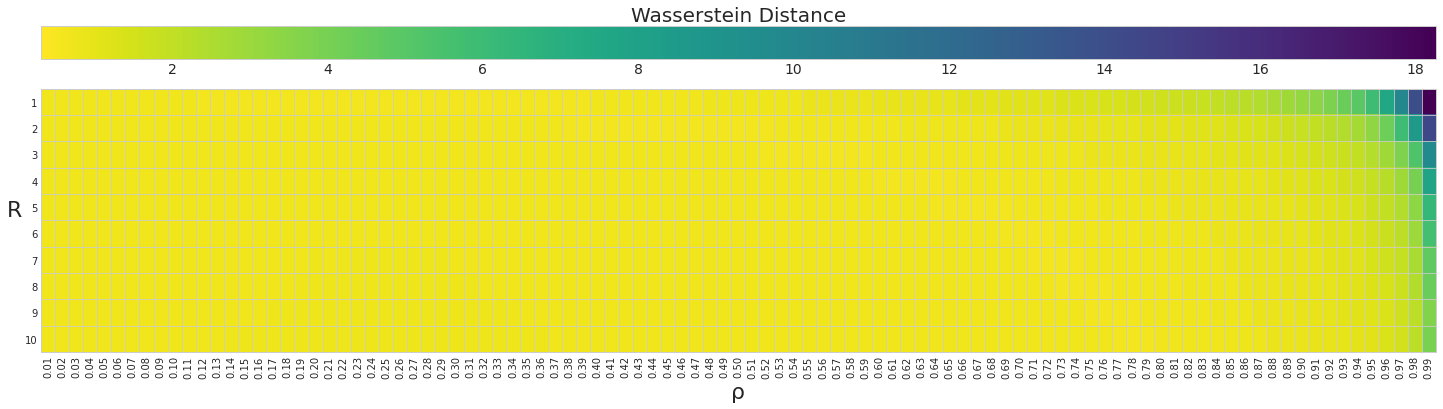

In [14]:
Rs = list(range(1, 11))
rhos = [round(r, 2) for r in np.linspace(0.01, 0.99, 99)]

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(25, 6),  gridspec_kw={"height_ratios":[0.125, 1]})
mappable = ax.imshow(WDs, aspect='auto', cmap='viridis_r', vmin=minW, vmax=maxW)
ax.set_ylabel('R', fontsize=22, rotation=0, labelpad=10)
ax.set_xlabel('ρ', fontsize=22, rotation=0)

# colorbar
cbar = fig.colorbar(mappable, orientation = "horizontal", cax=cax)
cbar.set_label('Wasserstein Distance', fontsize=20, labelpad=-70)
cbar.ax.tick_params(labelsize=14)

# y-ticks
ax.set_yticks([R - 0.5 for R in Rs])
ax.set_yticks([R - 1 for R in Rs], minor=True)
ax.set_yticklabels(Rs, minor=True)
ax.set_yticklabels([])

# x-ticks
ax.set_xticks([r - 0.5 for r in range(len(rhos))])
ax.set_xticks([r for r in range(len(rhos))], minor=True)
ax.set_xticklabels([])
ax.set_xticklabels([str.ljust(str(n), 4, '0') for n in rhos], minor=True, rotation=90,)

fig.savefig('deterministic-expon-dists.pdf', bbox_inches='tight')

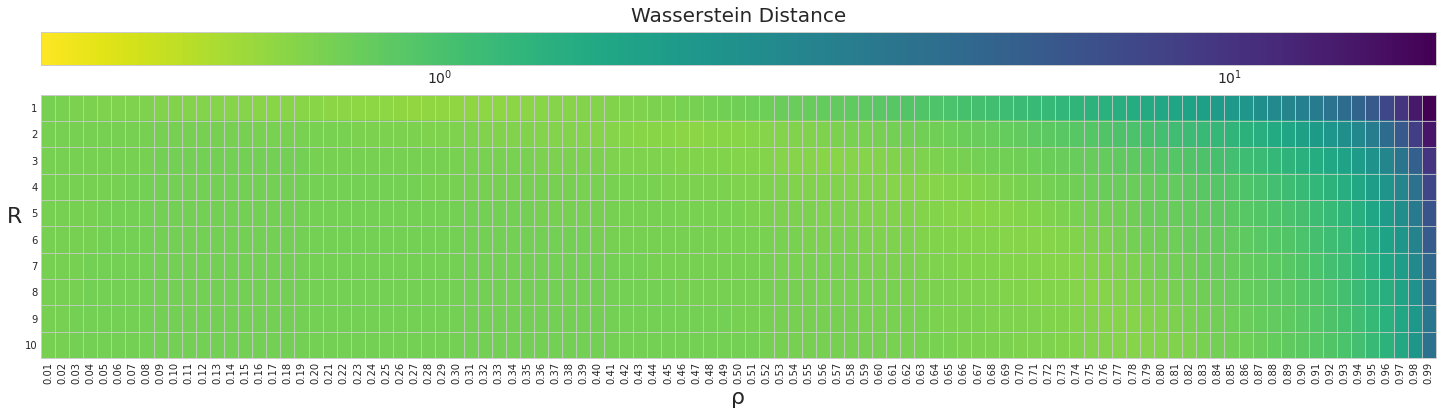

In [15]:
Rs = list(range(1, 11))
rhos = [round(r, 2) for r in np.linspace(0.01, 0.99, 99)]

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(25, 6),  gridspec_kw={"height_ratios":[0.125, 1]})
mappable = ax.imshow(WDs, aspect='auto', cmap='viridis_r',  norm=colors.LogNorm(vmin=minW, vmax=maxW))
ax.set_ylabel('R', fontsize=22, rotation=0, labelpad=10)
ax.set_xlabel('ρ', fontsize=22, rotation=0)

# colorbar
cbar = fig.colorbar(mappable, orientation = "horizontal", cax=cax)
cbar.set_label('Wasserstein Distance', fontsize=20, labelpad=-80)
cbar.ax.tick_params(labelsize=14)

# y-ticks
ax.set_yticks([R - 0.5 for R in Rs])
ax.set_yticks([R - 1 for R in Rs], minor=True)
ax.set_yticklabels(Rs, minor=True)
ax.set_yticklabels([])

# x-ticks
ax.set_xticks([r - 0.5 for r in range(len(rhos))])
ax.set_xticks([r for r in range(len(rhos))], minor=True)
ax.set_xticklabels([])
ax.set_xticklabels([str.ljust(str(n), 4, '0') for n in rhos], minor=True, rotation=90,)

fig.savefig('deterministic-expon-dists-logscale.pdf', bbox_inches='tight')

In [16]:
def get_percentile(data, R, rho, p):
    times = list(data[(R, rho)][data[(R, rho)]['cdf'] >= p]['sojourn_time'])
    if len(times) == 0:
        return np.nan
    return times[0]

In [17]:
Rs_full = []
rhos_full = []
#
p99_a = []
p999_a = []
p9999_a = []
p99999_a = []
#
p99_u = []
p999_u = []
p9999_u = []
p99999_u = []
p99_e = []
p999_e = []
p9999_e = []
p99999_e = []
p99_d = []
p999_d = []
p9999_d = []
p99999_d = []
for R in Rs:
    for rho in rhos:
        Rs_full.append(R)
        rhos_full.append(rho)
        #
        p99_a.append(get_percentile(approx_data, R, rho, 0.99))
        p999_a.append(get_percentile(approx_data, R, rho, 0.999))
        p9999_a.append(get_percentile(approx_data, R, rho, 0.9999))
        p99999_a.append(get_percentile(approx_data, R, rho, 0.99999))
        #
        p99_u.append(get_percentile(uniform_data, R, rho, 0.99))
        p999_u.append(get_percentile(uniform_data, R, rho, 0.999))
        p9999_u.append(get_percentile(uniform_data, R, rho, 0.9999))
        p99999_u.append(get_percentile(uniform_data, R, rho, 0.99999))
        p99_e.append(get_percentile(expon_data, R, rho, 0.99))
        p999_e.append(get_percentile(expon_data, R, rho, 0.999))
        p9999_e.append(get_percentile(expon_data, R, rho, 0.9999))
        p99999_e.append(get_percentile(expon_data, R, rho, 0.99999))
        p99_d.append(get_percentile(deterministic_data, R, rho, 0.99))
        p999_d.append(get_percentile(deterministic_data, R, rho, 0.999))
        p9999_d.append(get_percentile(deterministic_data, R, rho, 0.9999))
        p99999_d.append(get_percentile(deterministic_data, R, rho, 0.99999))

data = pd.DataFrame({
    'R': Rs_full,
    'rho': rhos_full,
    #
    'A99': p99_a,
    'A999': p999_a,
    'A9999': p9999_a,
    'A99999': p99999_a,
    #
    'U99': p99_u,
    'U999': p999_u,
    'U9999': p9999_u,
    'U99999': p99999_u,
    'E99': p99_e,
    'E999': p999_e,
    'E9999': p9999_e,
    'E99999': p99999_e,
    'D99': p99_d,
    'D999': p999_d,
    'D9999': p9999_d,
    'D99999': p99999_d,
})

In [18]:
data['pessimistic99'] = data['U99'] < data['E99']
data['pessimistic999'] = data['U999'] < data['E999']
data['pessimistic9999'] = data['U9999'] < data['E9999']
data['pessimistic99999'] = data['U99999'] < data['E99999']
data['pessimistic'] = data['pessimistic99'] & data['pessimistic999'] & data['pessimistic9999'] & data['pessimistic99999']

In [19]:
data.head()

R   rho   A99  A999  A9999  A99999   U99  U999  U9999  U99999  ...  E99999  \
0  1  0.01  4.69  7.07   9.47   11.91  2.04  2.91   2.94    2.94  ...    9.37   
1  1  0.02  4.77  7.23   9.74   12.29  2.17  3.21   4.67    4.67  ...    9.37   
2  1  0.03  4.85  7.39  10.00   12.68  2.43  3.14   4.67    4.67  ...    9.05   
3  1  0.04  4.93  7.55  10.27   13.06  2.57  3.62   4.67    4.67  ...    9.05   
4  1  0.05  5.01  7.72  10.53   13.45  2.71  3.67   4.67    4.67  ...    9.05   

    D99  D999  D9999  D99999  pessimistic99  pessimistic999  pessimistic9999  \
0  1.72  1.99   1.99    1.99           True            True             True   
1  1.84  2.19   2.46    2.46           True            True             True   
2  1.93  2.46   2.64    2.64           True            True             True   
3  1.96  2.60   2.95    2.95           True            True             True   
4  2.00  2.95   3.22    3.22           True            True             True   

   pessimistic99999  pessimistic  
0              True         True  
1              True         True  
2              True         True  
3              True         True  
4              True         True  

[5 rows x 23 columns]

In [20]:
data['pessimistic'].value_counts()

True     946
False     44
Name: pessimistic, dtype: int64

In [21]:
data.dropna()['pessimistic'].value_counts()

True    946
Name: pessimistic, dtype: int64

In [22]:
data[data['R']==1].set_index('rho')['U99']

rho
0.01      2.04
0.02      2.17
0.03      2.43
0.04      2.57
0.05      2.71
         ...  
0.95    103.60
0.96    129.35
0.97    171.20
0.98       NaN
0.99       NaN
Name: U99, Length: 99, dtype: float64

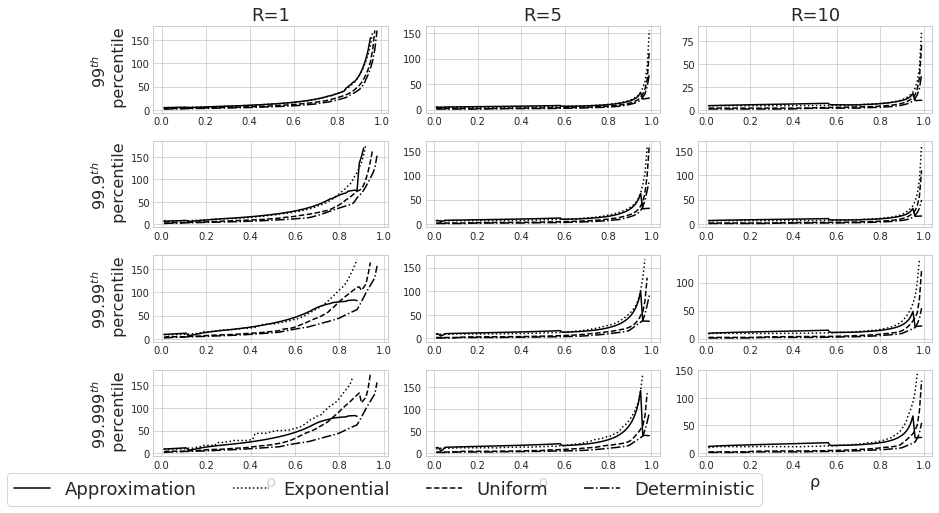

In [26]:
fig, axarr = plt.subplots(4, 3, figsize=(12, 7))

axarr[(0, 0)].set_title('R=1', fontsize=18)
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['A99'], c='black', linestyle='solid', label='Approximation')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['E99'], c='black', linestyle='dotted', label='Exponential')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['U99'], c='black', linestyle='dashed', label='Uniform')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['D99'], c='black', linestyle='dashdot', label='Deterministic')
axarr[(0, 0)].set_ylabel('$99^{th}$ \n percentile', fontsize=16)
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(1, 0)].set_ylabel('$99.9^{th}$ \n percentile', fontsize=16)
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(2, 0)].set_ylabel('$99.99^{th}$ \n percentile', fontsize=16)
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 0)].set_ylabel('$99.999^{th}$ \n percentile', fontsize=16)
axarr[(3, 0)].set_xlabel('ρ', fontsize=16)

axarr[(0, 1)].set_title('R=5', fontsize=18)
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['A99'], c='black', linestyle='solid')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['E99'], c='black', linestyle='dotted')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['U99'], c='black', linestyle='dashed')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['D99'], c='black', linestyle='dashdot')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['A99999'], c='black', linestyle='solid')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 1)].set_xlabel('ρ', fontsize=16)

axarr[(0, 2)].set_title('R=10', fontsize=18)
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['A99'], c='black', linestyle='solid')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['E99'], c='black', linestyle='dotted')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['U99'], c='black', linestyle='dashed')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['D99'], c='black', linestyle='dashdot')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['A99999'], c='black', linestyle='solid')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 2)].set_xlabel('ρ', fontsize=16)

fig.legend(ncol=4, fontsize=18, frameon=True, bbox_to_anchor=(0.8, 0.07))
plt.savefig('pessimism.pdf', bbox_inches='tight')
plt.tight_layout()

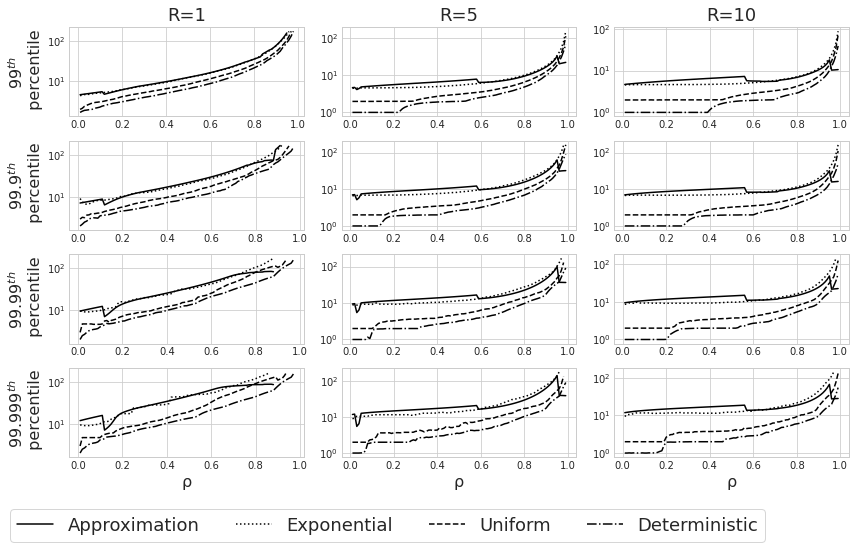

In [34]:
fig, axarr = plt.subplots(4, 3, figsize=(12, 7))

axarr[(0, 0)].set_title('R=1', fontsize=18)
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['A99'], c='black', linestyle='solid', label='Approximation')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['E99'], c='black', linestyle='dotted', label='Exponential')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['U99'], c='black', linestyle='dashed', label='Uniform')
axarr[(0, 0)].plot(data[data['R']==1].set_index('rho')['D99'], c='black', linestyle='dashdot', label='Deterministic')
axarr[(0, 0)].set_ylabel('$99^{th}$ \n percentile', fontsize=16)
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 0)].plot(data[data['R']==1].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(1, 0)].set_ylabel('$99.9^{th}$ \n percentile', fontsize=16)
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 0)].plot(data[data['R']==1].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(2, 0)].set_ylabel('$99.99^{th}$ \n percentile', fontsize=16)
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['A99999'], c='black', linestyle='solid')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 0)].plot(data[data['R']==1].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 0)].set_ylabel('$99.999^{th}$ \n percentile', fontsize=16)
axarr[(3, 0)].set_xlabel('ρ', fontsize=16)

axarr[(0, 1)].set_title('R=5', fontsize=18)
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['A99'], c='black', linestyle='solid')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['E99'], c='black', linestyle='dotted')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['U99'], c='black', linestyle='dashed')
axarr[(0, 1)].plot(data[data['R']==5].set_index('rho')['D99'], c='black', linestyle='dashdot')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 1)].plot(data[data['R']==5].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 1)].plot(data[data['R']==5].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['A99999'], c='black', linestyle='solid')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 1)].plot(data[data['R']==5].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 1)].set_xlabel('ρ', fontsize=16)

axarr[(0, 2)].set_title('R=10', fontsize=18)
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['A99'], c='black', linestyle='solid')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['E99'], c='black', linestyle='dotted')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['U99'], c='black', linestyle='dashed')
axarr[(0, 2)].plot(data[data['R']==10].set_index('rho')['D99'], c='black', linestyle='dashdot')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['A999'], c='black', linestyle='solid')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['E999'], c='black', linestyle='dotted')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['U999'], c='black', linestyle='dashed')
axarr[(1, 2)].plot(data[data['R']==10].set_index('rho')['D999'], c='black', linestyle='dashdot')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['A9999'], c='black', linestyle='solid')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['E9999'], c='black', linestyle='dotted')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['U9999'], c='black', linestyle='dashed')
axarr[(2, 2)].plot(data[data['R']==10].set_index('rho')['D9999'], c='black', linestyle='dashdot')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['A99999'], c='black', linestyle='solid')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['E99999'], c='black', linestyle='dotted')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['U99999'], c='black', linestyle='dashed')
axarr[(3, 2)].plot(data[data['R']==10].set_index('rho')['D99999'], c='black', linestyle='dashdot')
axarr[(3, 2)].set_xlabel('ρ', fontsize=16)

for i in range(4):
    for j in range(3):
        axarr[(i, j)].set_yscale('log')

fig.legend(ncol=4, fontsize=18, frameon=True, bbox_to_anchor=(.9, 0.0))
plt.savefig('pessimism_logscale.pdf', bbox_inches='tight')
plt.tight_layout()